In [1]:
!pip install wandb --upgrade

You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/gt/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import sys

IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")

sys.path.append("/kaggle/input/microstructure-reconstruction")
sys.path.append("/home/matias/microstructure-reconstruction")
sys.path.append("/content/gdrive/MyDrive/microstructure-reconstruction")

from imp import reload
from pathlib import Path
from pprint import pprint
from typing import Callable, List, Optional, Union
from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
import numpy as numpy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision.io import read_image
import torchvision.models as models
from tqdm import tqdm
from copy import deepcopy
import tools
import wandb
from time import time
from custom_datasets.dataset import SinglePhotoDataset, NChannelPhotosDataset

repo_path = tools.wandb_login()

seed = 42

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}
print(f"[INFO]: Computation device: {device}")


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc


[INFO]: Computation device: cpu


In [3]:
run = wandb.init(
    project="microstructure-reconstruction",
    group="Naive Network",
    job_type="test",
)


In [4]:
config = wandb.config
config.train_val_split = 0.7
config.seed = 42
config.batch_size = 32
config.learning_rate = 0.01
config.device = device
config.momentum = 0.9
config.architecture = "VGG"
config.input_width = 64
config.weight_decay = 0.0005
config.epochs = 100
config.frac_sample = 1 / 6
# config.total_layers = 24
# config.fixed_layers = 0
torch.manual_seed(config.seed)


In [5]:
topLevelFolder = repo_path / "REV1_600"
path_to_revs = topLevelFolder / "REV1_6003D_model"
path_to_fabrics = topLevelFolder / "fabrics.txt"
path_to_slices = topLevelFolder / "REV1_600Slices"


In [6]:
data_at = run.use_artifact("raw_fabrics" + ":3_images")
data_dir = data_at.download()
fabrics_df = tools.convert_table_to_dataframe(data_at.get("fabrics"))
fabrics_df = fabrics_df.sample(frac=config.frac_sample, random_state=config.seed)
fabrics_df["photos"] = fabrics_df["photos"].apply(
    func=lambda photo_paths: [str(repo_path / Path(x)) for x in photo_paths]
)

In [7]:
train_df, test_df = train_test_split(
    fabrics_df,
    train_size=config.train_val_split,
    random_state=config.seed,
    shuffle=True,
)

transform = transforms.Compose(
    [
        transforms.CenterCrop(207),
        transforms.Resize((config.input_width, config.input_width)),
        transforms.ToTensor(),
        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
    ]
)

train_dataset = SinglePhotoDataset(train_df, normalization=True, transform=transform)
validation_dataset = SinglePhotoDataset(
    test_df, normalization=[train_dataset.max, train_dataset.min], transform=transform
)


In [8]:
class VGG11(nn.Module):
    def __init__(self, input_channel, input_height, output_size):
        super(VGG11, self).__init__()
        self.in_channels = input_channel
        self.output_size = output_size
        # convolutional layers 
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2)
        )
        input_fc = int((input_height / (2**2))**2 * 128)
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=input_fc, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.output_size)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
        
model = VGG11(input_channel=1, input_height =config.input_width, output_size=23).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

[INFO]: 151,171,863 total parameters.
[INFO]: 151,171,863 trainable parameters.


In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size,
                        shuffle=True, **kwargs)

validation_dataloader = DataLoader(validation_dataset, batch_size=config.batch_size,
                        shuffle=False, **kwargs)
loss = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, momentum=config.momentum, 
                      weight_decay=config.weight_decay)

config.model_type = type(model)
config.loss_type = type(loss)
config.optimizer_type = type(optimizer)

torch.Size([23])


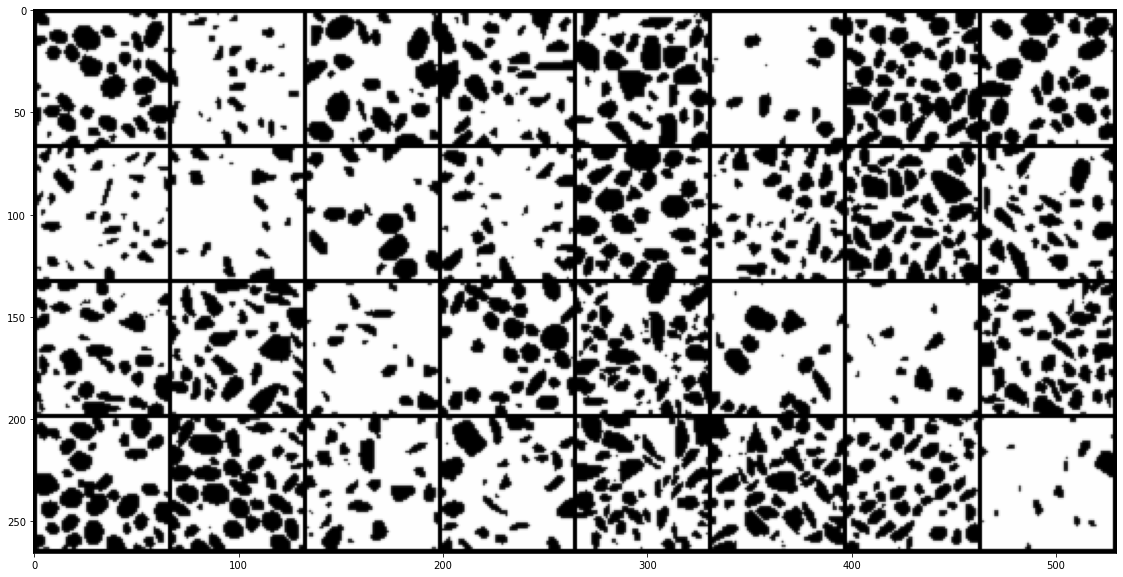

In [10]:
first_batch = next(iter(train_dataloader))
images = first_batch[0]
labels = first_batch[1]
print(labels[0].shape)

labels = first_batch[1]
grid = utils.make_grid(images)

fig = plt.figure(figsize=(40, 10))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()


In [11]:
train_loss, val_loss, max_error = [], [], []
config.epochs = 100
nb_epochs = deepcopy(config.epochs)
config.epochs = 0
for epoch in range(config.epochs, nb_epochs):
    current_train_loss = tools.train(model, device, train_dataloader, optimizer, loss)
    current_val_loss, _, current_max_error = tools.validate(
        model,
        device,
        validation_dataloader,
        loss,
        validation_dataset.min,
        validation_dataset.max,
    )

    train_loss.append(current_train_loss)
    val_loss.append(current_val_loss)
    max_error.append(current_max_error)
    print(
        "{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}\n{:<13}{:<30}".format(
            "Epoch",
            epoch,
            "train loss",
            current_train_loss,
            "val loss",
            current_val_loss,
            "max error",
            current_max_error,
        )
    )
    if epoch >= 1:
        wandb.log(
            {
                "train_loss": current_train_loss,
                "val_loss": current_val_loss,
                "max_error": current_max_error,
                "epoch": epoch,
            }
        )
        config.epochs = epoch


  5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

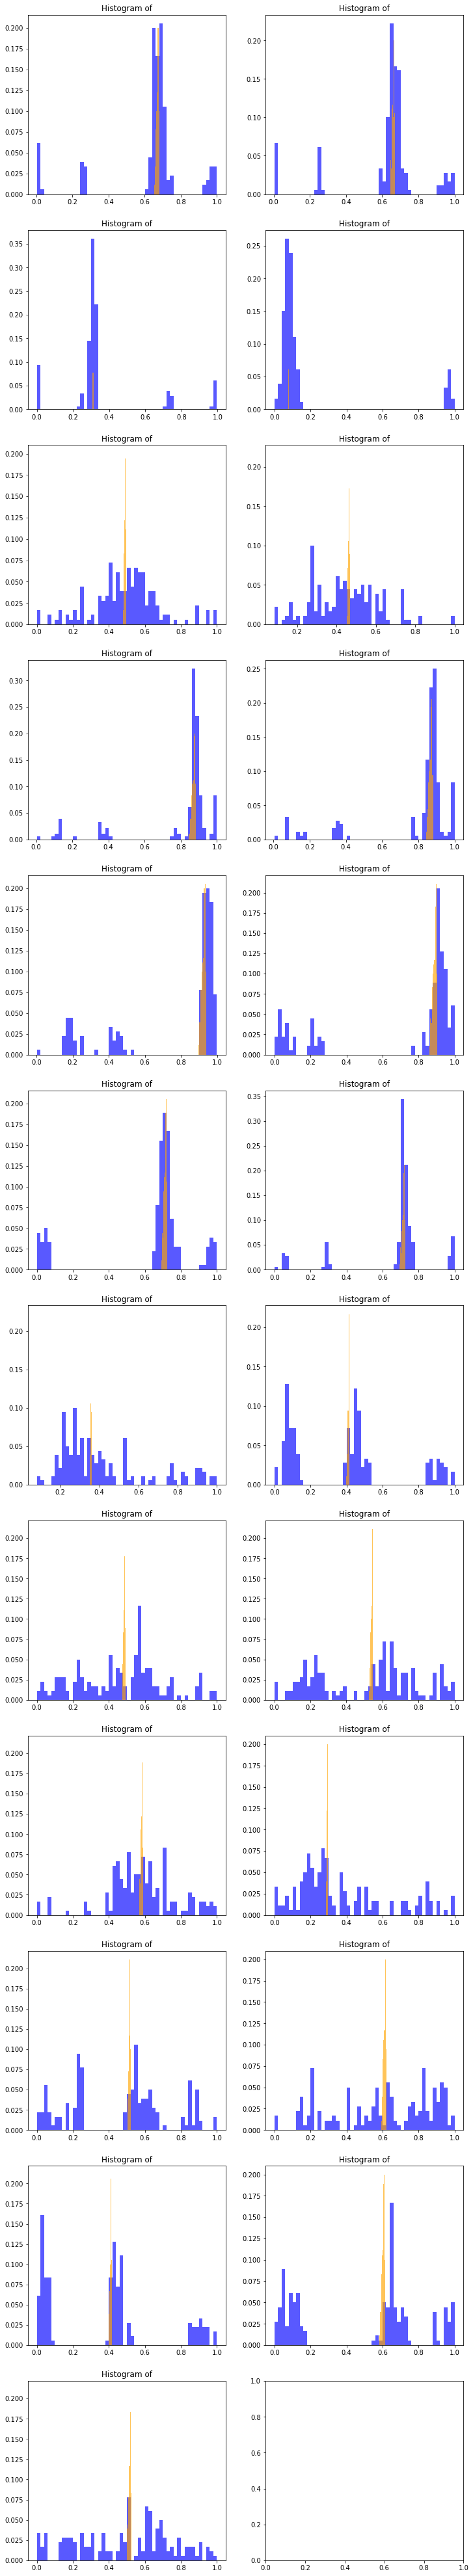

In [22]:
outputs, targets = tools.compute_outputs(model, device, validation_dataloader)
x = outputs.cpu().numpy()
y = targets.cpu().numpy()
n = 6
nb_bins = 50
fig, axs = plt.subplots(23 // 2 + 1, 2, figsize=(n * 2, n * (23 // 2 + 1)))
for i in range(23):
    hist_y = axs[i//2, i%2].hist([y[:, i]], color="blue", bins=nb_bins, alpha=0.65, weights=[1/y.shape[0]]*y.shape[0])
    hist = axs[i//2, i%2].hist([x[:, i]], color="orange", alpha=0.65, weights=[1/x.shape[0]]*x.shape[0])
    # axs[i//2, i%2].axvline(x[:, i].mean(), color="red", linestyle="dashed", linewidth=3)
    # axs[i//2, i%2].axvline(y[:, i].mean(), color="purple", linestyle="dashed", linewidth=3)
    axs[i//2, i%2].set_title(f'Histogram of')
plt.show()